# Análise da violência doméstica por estado:

O objetivo desse trabalho é a classificação de municípios paraenses quanto aos mecanismos de proteção e assistência à mulheres vítimas de violência doméstica. Inicialmente os dados são oriundos da base de dados do Instituto Brasileiro de Geografia e Estatística (IBGE).
Para a classificação, será utilizado o método multi-critério ELECTRE-TRI.

A biblioteca Requests foi utilizada para obter os dados da API do IBGE através de requisição, enquando a biblioteca Pandas foi responsável pelo tratamento e análise de dados.


## 1. Importar os nomes dos municípios da região pesquisada:

url é a string de requisição à API. Ela segue os critérios definidos na documentação da API que poderá ser acessada através desse link.

res é a variável que recebe os dados (json) da API.

df_munic é o dataframe principal onde será estruturado os dados obtidos da API.

<div class="alert alert-success">
      Ao final dessa etapa, será apresentada uma tabela com o código e nome do município.
</div>

In [487]:
import pandas as pd
import requests as rq

url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
   
res = rq.request("GET", url)

#Cria um data frame com Coluna Municípios
if res.status_code == 200:
    df_munic = pd.DataFrame({'id': [], 'localidade': []})
    
    for id, munic in enumerate(res.json()):
        df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]

#df_munic

### 1.1. - Preparar a URL para obter os dados e definindo o dataframe principal

Com ajuda da documentação da API do IBGE, podemos obter o código dos indicadores que desejamos selecionar. Para o estudo de caso do projeto, selecionamos os seguinte indicadores:

    90201: 'Possui_delegacias_especializadas',
    90335:'Executa_programas_acoes_especificas',
    90358: 'Possui_legislacao_especifica_violencia_contra_a_mulher',
    90626:'Possui_direitos_ou_politicas_para_mulheres',
    90640:'Possui_programas_direitos_humanos_protecao_mulheres_vitimas'
    

In [488]:
indicadores = ['90201','90335','90358','90626','90640']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

#Adiciona os indicadores na url
for i, ind in enumerate(indicadores):
    if i != (len(indicadores)-1):
        url += ind + '|'
    else:
        url += ind + '/'

def urlResultadosPorMunicipos(url, df):
    url += 'resultados/'    

    for i, row in df_munic.iterrows():
        if i != (len(df)-1):
            url += row.id + '|'
        else:
            url += row.id + '/'
    
    return url

url = urlResultadosPorMunicipos(url, df_munic)

res = rq.request("GET", url)

#res.json()


## 2. Obtendo dados da rede de proteção e assistência de cada município.

In [ ]:
if res.status_code == 200:
    
    #Percorre o json e insere os dados no dataframe principal para cada indicador selecionado.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #Substitui as palavras "Sim" e "Não" para informações binárias 1 e 0.
        df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 if x['2019']  == 'Sim' else 0)
        df_munic = pd.merge(df_munic, df_temp, on="id")
        

df_munic

In [ ]:
#Definie a quantidade de mecanismos de proteção e assistência da mulher 
#e agrega os dados ao dataframe principal.

df_munic['Rede_de_Protecao_assistencia'] = df_munic[90201] + df_munic[90335] + df_munic[90358] + df_munic[90626] + df_munic[90640]

df_munic = df_munic[['id', 'localidade', 'Rede_de_Protecao_assistencia']]

df_munic

#### QUERYs ####
#dados.query('Rede_de_Protecao_assistencia_(2019) >= 5')

#dados.query('Rede_de_Protecao_assistencia_(2019) > 2 & Rede_de_Protecao_assistencia_(2019) < 5')

#dados.query('Rede_de_Protecao_assistencia_(2019) < 3')

### Obtendo coluna IDH

In [ ]:
# Pesquisar dados mais atuais em :
# https://www.redesocialdecidades.org.br/dados-abertos/api


url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# Correção do valor "-" para "0" em mojuí dos campos
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

#df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp = pd.json_normalize(x[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)

df_temp = df_temp[['id', 'IDH']]

df_munic = pd.merge(df_munic, df_temp, on='id')

df_munic

### Obtendo Renda Per Capta

In [ ]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

df_temp = pd.json_normalize(res.json()[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)

df_temp = df_temp[['id', 'PIB']]

df_munic = pd.merge(df_munic, df_temp, on='id')

df_munic

### Obtendo Índice de GINI

In [ ]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = urlResultadosPorMunicipos(url, df_munic)
        
res = rq.request("GET", url)

# Correção do valor "-" para "0" em mojuí dos campos
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})


#df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp = pd.json_normalize(x[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)

df_temp = df_temp[['id', 'GINI']]

df_munic = pd.merge(df_munic, df_temp, on='id', how='left')

df_munic

### Transformando colunas em tipos numéricos

In [495]:

df_munic['Rede_de_Protecao_assistencia'] = pd.to_numeric(df_munic['Rede_de_Protecao_assistencia'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

# Normalização dados

A normalização consiste em recalcular os valores das colunas para intervalos entre 0 e 1. Este procedimento torna-se necessário para que escalas diferentes não afetem a acurácia do modelo. Nesse caso, serão recalculadas somente as colunas que possuem valores com escalas fora do intervalor de 0 e 1.
O calculo é feito dividindo o valor da alternativa pela soma dos valores da coluna:

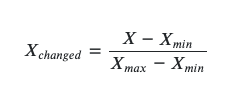



In [496]:
columns = df_munic[['Rede_de_Protecao_assistencia', 'IDH', 'PIB', 'GINI']]

#print(type(y))

for i in columns:
    mx = df_munic[[i]].max()[0]
    mn = df_munic[[i]].min()[0]
    df_munic[[i]] = (df_munic[[i]] - mn) / (mx - mn)
    
df_munic

,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI
0,150010,Abaetetuba,0.8,0.841823,0.014354,0.816327
1,150013,Abel Figueiredo,0.2,0.833780,0.021329,0.755102
2,150020,Acará,0.6,0.678284,0.028983,0.734694
3,150030,Afuá,0.6,0.655496,0.014235,0.795918
4,150034,Água Azul do Norte,0.2,0.756032,0.036808,0.755102
...,...,...,...,...,...,...
139,150815,Uruará,0.2,0.789544,0.028298,0.775510
140,150820,Vigia,0.0,0.827078,0.006436,0.734694
141,150830,Viseu,0.2,0.690349,0.009128,0.755102
142,150835,Vitória do Xingu,0.8,0.798928,0.925422,0.775510


In [ ]:
df_munic.query("IDH < 0.7")

# Aplicação do Método Multicritério ELECTRE-TRI

### Instalação da biblioteca pyDecision

In [14]:
#!pip install pyDecision

### Configurações dos parânmetros de classificação

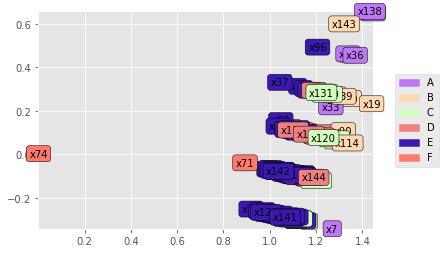

,ID,Class
0,x1,2
1,x2,4
2,x3,4
3,x4,4
4,x5,4
...,...,...
139,x140,4
140,x141,4
141,x142,4
142,x143,1


In [408]:
#require Libraries
import numpy as np

from pyDecision.algorithm import electre_tri_b

#Parameters

Q = [0.1, 0.1, 0.1, 0.1]
P = [0.2, 0.2, 0.2, 0.2]
V = [1, 1, 1, 1]
W = [0.5, 1, 0.3, 1]
B = [[0.1, 0.48, 0.01, 0.37],
     [0.2, 0.57, 0.03, 0.68],
     [0.3, 0.62, 0.04, 0.70],
     [0.4, 0.68, 0.08, 0.72],
     [0.5, 0.69, 0.50, 0.78]]



columns = df_munic[['Rede_de_Protecao_assistencia', 'IDH', 'PIB', 'GINI']]

dataset = pd.DataFrame(columns).to_numpy()
#len(dataset)

# Call Electre Tri-B Function
classification = electre_tri_b(dataset, W , Q , P , V , B, cut_level = 0.60, verbose = False, rule = 'pc', graph = True)

d = []
for i in range(0, len(classification)):
     d.append({'ID': 'x' + str(i+1), 'Class': str(classification[i])})
     #print('x' + str(i+1)+": " + " Class " + str(classification[i]))

xd = pd.DataFrame(d)
#xd




### Obtendo o resultado da classificação

In [498]:
df_munic['idx'] = xd['ID']
df_munic['classe'] = xd['Class']

df_munic.query("classe == '5'")


,id,localidade,Rede_de_Protecao_assistencia,IDH,PIB,GINI,denuncias,idx,classe
70,150450,Melgaço,0.2,0.560322,0.004010,0.673469,8,x71,5
73,150475,Mojuí dos Campos,0.0,0.000000,0.018525,0.000000,0,x74,5


### Obtendo quantidade de denúncias por municípios
#### fonte: Ministério da Mulher, Família e Direitos Humanos (https://www.gov.br/mdh/pt-br/acesso-a-informacao/dados-abertos/ligue180)

In [ ]:
#Abrindo arquivo json
dd = pd.read_json('casos_violencia_por_municipio.json')

df_munic['denuncias'] = dd['casos']

df_munic

#classe = pd.Series(data=classification, index=range(144), name="classificacao")
#dfClass = pd.merge(df_munic[['id', 'localidade']], classe, left_index=True, right_index=True)
#dfClass.to_excel('classificacao_final.xlsx')

### Biblioteca GeoPandas para o mapeamento dos municípios Paraenses

#### Leitura do arquivo com a geometria dos estados

In [ ]:
import geopandas as gpd

gdf_munic = gpd.read_file('munics.geojson')

#gdf_munic.head()
for value in gdf_munic['id']:
    gdf_munic['id'].replace(to_replace=value, value=value[:6], regex=True,inplace=True)


df_teste = pd.merge(df_munic, gdf_munic, on='id', how='left')

df_teste = df_teste[['id', 'localidade', 'geometry']]

df_teste['classe'] = classification

df_teste

### Plotagem do gráfico

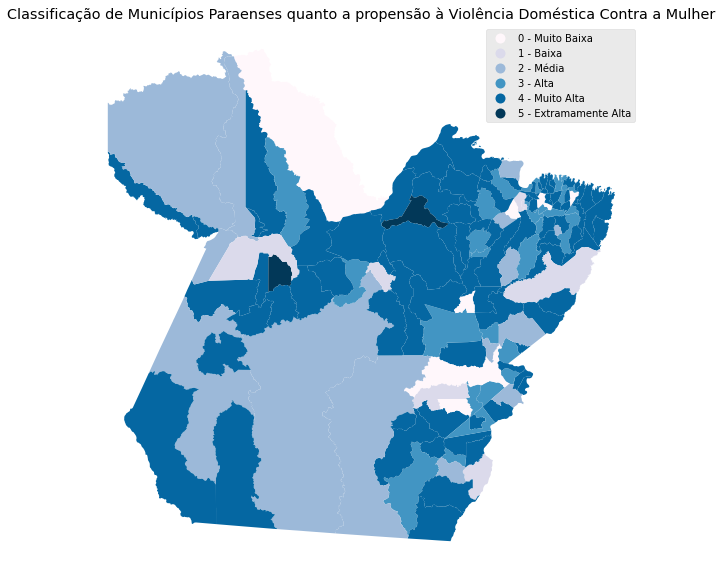

In [500]:


df_teste['legenda'] = df_teste['classe'].map({5: '5 - Extramamente Alta', 4: '4 - Muito Alta', 3: '3 - Alta', 2: '2 - Média', 1: '1 - Baixa', 0: '0 - Muito Baixa '})
df_teste['classe'] = classification

gpd_teste = gpd.GeoDataFrame(df_teste)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('mycmap', [(0.22, 0.73, 0.28), (1, 0.76, 0), (0.91, 0.19, 0.16)])

ax = gpd_teste.plot('legenda', categorical=True, legend=True, legend_kwds={'loc': 'upper right'}, figsize=(10,10), cmap='PuBu')
#ax = gpd_teste.plot(column='legenda', categorical=True, legend=True, edgecolor="k", figsize=(6,6), cmap=cmap)


ax.set(title='Classificação de Municípios Paraenses quanto a propensão à Violência Doméstica Contra a Mulher')
ax.set_axis_off()

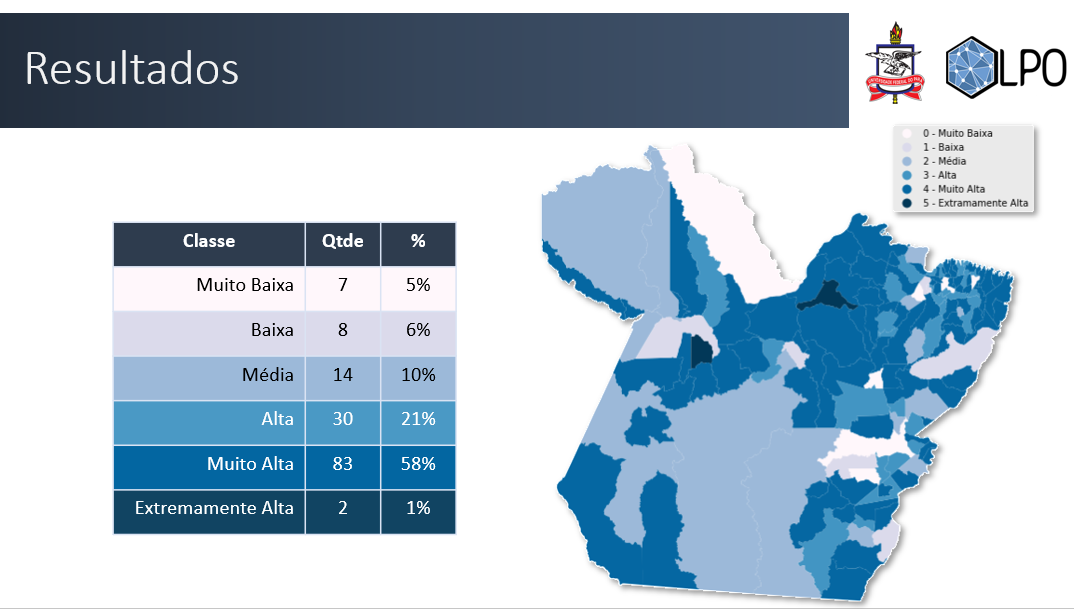